<a href="https://colab.research.google.com/github/ManojBhuma/NLP/blob/master/NLP_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


In [0]:
dataset = pd.read_csv('/content/housing.csv') 
dataset = dataset.dropna()
print("Here are the first five rows of the dataset:") 
dataset.head()


Here are the first five rows of the dataset:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [0]:
Y = dataset['median_house_value']
X = dataset.loc[:,'longitude':'median_income']


In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
x_train_np = x_train.to_numpy() 
y_train_np = y_train.to_numpy()
x_test_np = x_test.to_numpy() 
y_test_np = y_test.to_numpy()


In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset

In [0]:
class CnnRegressor(torch.nn.Module): 
  def __init__(self, batch_size, inputs, outputs):
    super(CnnRegressor, self).__init__() 
    self.batch_size = batch_size 
    self.inputs = inputs 
    self.outputs = outputs
    self.input_layer = Conv1d(inputs, batch_size, 1)
    self.max_pooling_layer = MaxPool1d(1)
    self.conv_layer = Conv1d(batch_size, 128, 1)
    self.flatten_layer = Flatten()
    self.linear_layer = Linear(128, 64)
    self.output_layer = Linear(64, outputs)
  def feed(self, input): 
    input = input.reshape((self.batch_size, self.inputs, 1))
    output = relu(self.input_layer(input))
    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer(output))
    output = self.flatten_layer(output)
    output = self.linear_layer(output)
    output = self.output_layer(output) 
    return output

    


In [0]:
from torch.optim import SGD
from torch.nn import L1Loss
!pip install pytorch-ignite 
from ignite.contrib.metrics.regression.r2_score import R2Score
batch_size = 64
model = CnnRegressor(batch_size, X.shape[1], 1)
model.cuda()


CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model, dataset, train = False, optimizer = None): 
  performance = L1Loss() 
  score_metric = R2Score()
  avg_loss = 0
  avg_score = 0
  count = 0 
  for input, output in iter(dataset): 
    predictions = model.feed(input)
    loss = performance(predictions, output)
    score_metric.update([predictions, output]) 
    score = score_metric.compute()
    if(train): 
      optimizer.zero_grad()
      optimizer.step()
    avg_loss += loss.item()
    avg_score += score
    count += 1
  return avg_loss / count, avg_score / count


epoch1:
	loss =206909.43862107623
	R2 score =-3.1149300591649896
epoch2:
	loss =206869.8265835202
	R2 score =-3.167175452098705
epoch3:
	loss =206892.81446188342
	R2 score =-3.1748417145726116
epoch4:
	loss =206871.8971412556
	R2 score =-3.173026323078867
epoch5:
	loss =206876.92138452915
	R2 score =-3.1927537075277956


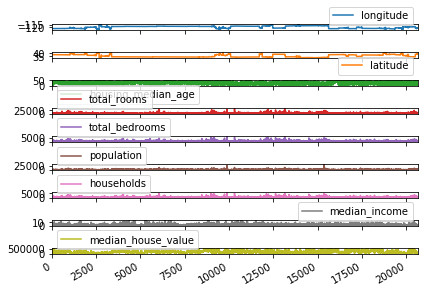

<Figure size 432x288 with 0 Axes>

In [0]:
epochs = 5
optimizer = SGD(model.parameters(),lr=1e-5)

inputs=torch.from_numpy(x_train_np).cuda().float()
outputs=torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()

tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)

for epoch in range(epochs):
  avg_loss,avg_r2_score=model_loss(model,loader,train=True, optimizer=optimizer)

  print("epoch"+str(epoch+1)+ ":\n\tloss ="+ str(avg_loss)+ "\n\tR2 score =" + str(avg_r2_score))


dataset.plot(subplots=True)
plt.tight_layout()
plt.show()
plt.savefig('plot.png')

In [0]:
inputs = torch.from_numpy(x_test_np).cuda().float() 
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()
tensor = TensorDataset(inputs, outputs) 
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
avg_loss, avg_r2_score = model_loss(model, loader) 
print("The model's L1 loss is: " + str(avg_loss)) 
print("The model's R^2 score is: " + str(avg_r2_score))
